In [ ]:
import json
import numpy as np
def save_json(data, filepath=r'new_data.json'):
    with open(filepath, 'w', encoding='utf-8') as fp:
        json.dump(data, fp, indent=4)
def min_max_normalize(data):
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    
    normalized_data = (data - min_vals) / (max_vals - min_vals)
    
    return normalized_data


In [ ]:
from sklearn.manifold import MDS, SpectralEmbedding, TSNE, LocallyLinearEmbedding
from sklearn.decomposition import PCA, KernelPCA
import matplotlib.pyplot as plt
import math
def dr(X, method="MDS"):
    if method == "MDS":
        embedding = MDS(n_components=2)
    elif method == "spectral":
        embedding = SpectralEmbedding(n_components=2)
    elif method == "tsne":
        embedding = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=min(X.shape[0]-1, min(70, max(5, (X.shape[0]-1)//5))))
        print(embedding.perplexity)
    elif method == "locallylinear":
        embedding = LocallyLinearEmbedding(n_components=2)
    elif method == "pca":
        embedding = PCA(n_components=2)
    elif method == "kernelpca":
        embedding = KernelPCA(n_components=2, kernel='sigmoid')
    X_transformed = embedding.fit_transform(X)
    return X_transformed

def plot(XY):
    plt.figure(figsize=(8, 6))
    plt.scatter(XY[:, 0], XY[:, 1])
    plt.title('Scatterplot')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

In [ ]:
import glob
from collections import defaultdict
def organize_chunk_topis():
    interview_files = glob.glob('../data/result/chunk_summaries/*.json')
    topic_chunks_dict = defaultdict(list)
    for interview_file in interview_files:
        chunks = json.load(open(interview_file, 'r'))
        for chunk in chunks:
            topic_chunks_dict[chunk['topic']].append(chunk['id'])
    return topic_chunks_dict

In [ ]:
topic_chunks_dict = organize_chunk_topis()
for topic, chunks in topic_chunks_dict.items():
    print(topic, len(chunks))
print(topic_chunks_dict.keys())

In [ ]:
import json
from pprint import pprint
import numpy as np
# dataset = json.load(open('../data/result/chunk_embeddings/1129/all.json'))
# data_embeddings = [data['embedding'] for data in dataset.values()]
# data_embeddings = [embedding for embedding in data_embeddings if embedding != 'No content' ]
# data_embeddings = np.array(data_embeddings)
# data_embeddings = json.load(open('../data/result/keyword_embeddings.json'))
# data_embeddings = np.array(list(data_embeddings.values()))
dataset = json.load(open('../data/result/chunk_embeddings/all.json'))
data_embeddings = {data['id']:data['embedding'] for data in dataset.values()}
topic_chunks_dict = organize_chunk_topis()
coordinates = {}
for topic, chunk_ids in topic_chunks_dict.items():
    print(topic)
    chunk_embeddings = np.array([data_embeddings[chunk_id] for chunk_id in chunk_ids])
    print(chunk_embeddings.shape)
    if chunk_embeddings.shape[0] == 1:
        XY = np.array([[0.5, 0.5]])
    else:
        XY = dr(chunk_embeddings, 'tsne')
        plot(XY)
        XY = min_max_normalize(XY)
    for chunk_id, coordinate in zip(chunk_ids, XY):
        coordinates[chunk_id] = coordinate.tolist()
save_json(coordinates, r'../data/result/chunk_coordinates.json')

In [39]:
from pprint import pprint
import itertools
from numpy.linalg import norm
import numpy as np
import json

def similarity(v1, v2):
    v1 = np.array(v1)
    v2 = np.array(v2)
    return np.dot(v1,v2)/(norm(v1)*norm(v2))
all_chunks = list(json.load(open('../data/result/chunk_embeddings/all.json')).values())
chunk_similarities = []
for c1, c2 in itertools.combinations(all_chunks, 2):
    # c1_embeddings = [message['embedding'] for message in chunk_messages[c1]]
    # c2_embeddings = [message['embedding'] for message in chunk_messages[c2]]
    # pairwise_similarities = [similarity(m1, m2) for m1 in c1_embeddings for m2 in c2_embeddings]
    # cluster_similarity = max(pairwise_similarities)
    c1_embedding = c1['embedding']
    c2_embedding = c2['embedding']
    cluster_similarity = similarity(c1_embedding, c2_embedding)
    c1_id = c1['id']
    c2_id = c2['id']
    chunk_similarities.append((c1_id, c2_id, cluster_similarity))
save_json(chunk_similarities, '../data/result/chunk_similarities.json')

926
[[-0.0023488  -0.02190386  0.00785906 ...  0.00078951  0.00129613
  -0.02696493]
 [ 0.02399973 -0.00046937 -0.00406707 ... -0.00075838 -0.00535564
  -0.03315399]
 [ 0.00990476 -0.00912058  0.00548224 ... -0.00991183  0.00098023
  -0.01137423]
 ...
 [-0.03955183 -0.01071714 -0.01229258 ...  0.0080914   0.01423424
   0.00722768]
 [-0.02953434 -0.01080439 -0.00111827 ...  0.00223654  0.00590546
  -0.01457009]
 [ 0.01687683  0.01075195 -0.01139186 ... -0.00070188  0.01938023
  -0.004613  ]]


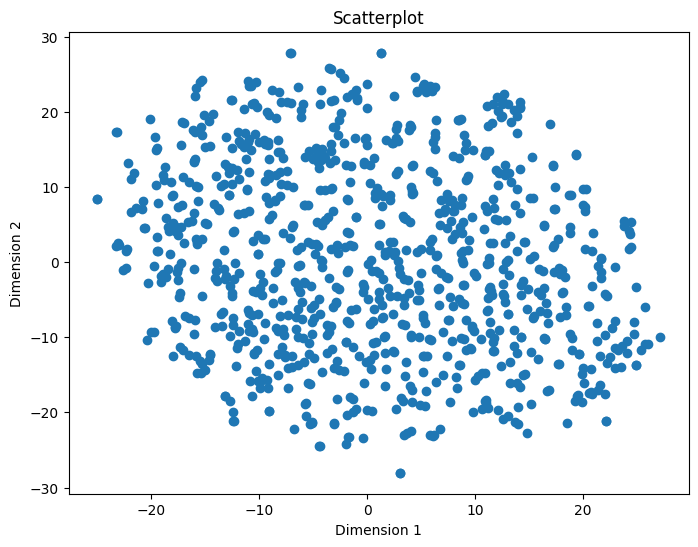

In [40]:
node_coordinates = {}
nodes = json.load(open('../data/result/keyword_embeddings.json'))
print(len(nodes))
embeddings = np.array(list(nodes.values()))
print(embeddings)
node_ids = list(nodes.keys())
XY = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=70, metric='cosine').fit_transform(embeddings)
# XY = MDS(n_components=2).fit_transform(embeddings)
# XY = reducer.fit_transform(embeddings)
plot(XY)
XY = min_max_normalize(XY)
for node_id, coordinate in zip(node_ids, XY):
    node_coordinates[node_id] = coordinate.tolist()
save_json(node_coordinates, r'../data/result/keyword_coordinates.json')

In [ ]:
from collections import defaultdict
import json
dataset = json.load(open('../data/result/chunk_embeddings/1029/all_messages.json'))
chunk_messages = defaultdict(list)
for message in dataset:
    chunk_id = message['interview_id'] + "_" + str(message['chunk_index'])
    chunk_messages[chunk_id].append(message)